In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Modules

In [1]:
# Modules -- 
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

import datetime 
from datetime import datetime
import time
import dateutil.parser
import random

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

bokeh.io.output_notebook()

pd.set_option('max_columns', 500)
# pd.set_option('max_rows', 800)

import scipy
import statsmodels.api as sm
import datetime as dt
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Loading BokehJS ...

The KPN formula in the streets:
* KPN shop -- only **KPN**
* TELFORT shop (KPN subsidiary) -- only **Telfort**
* MULTIBRAND store -- combines the brands **KPN, Telfort and XS4ALL**,
* KPN XL store -- combines the consumer and small business segments.

Please send the **two files before noon the day prior** to the walkthrough and presentation sessions to Tom

# Data, Wrangling, Preliminaries

In [2]:
case0 = pd.read_csv('dataset_shops.csv',
                   usecols = ['date', 'shop_id', 'committed_revenues_main_inc_vat', 'place', 
                              'shop_formula', 'dist_shop_closest_km', 'no_retail_shops', 
                              'no_companies', 'perc_owned_vs_rented_houses', 
                              'avg_value_household', 'avg_household_size', 'no_residents'])

# Other columns: tons of NA, not particularly relevant to question of interest (at first pass anyway)

case0.date = pd.to_datetime(case0.date)

# Levels of categoricals -- 
# for c in case.columns:
#     if type(case[c][0]) != np.float64:
#         print(c, len(case[c].unique()))

In [4]:
# NA EDA --- 

for c in [case0.columns]:
    print(case0[c].isna().sum())

c_subset = case0[pd.isnull(case0).any(axis=1)].copy()
print()
for c in ['shop_id', 'place', 'shop_formula']:
    print(c, c_subset[c].unique())
    
# All NAs in four KPN shop/places

date                                  0
shop_id                               0
committed_revenues_main_inc_vat       0
place                                 0
shop_formula                          0
dist_shop_closest_km                  0
no_retail_shops                     899
no_companies                        899
perc_owned_vs_rented_houses         899
avg_value_household                1849
avg_household_size                  899
no_residents                        899
dtype: int64

shop_id ['bd169' 'bd172' 'mt009' 'rt027']
place ['roosendaal' 'bergen op zoom' 'sittard' 'spijkenisse']
shop_formula ['KPN winkel']


* **No time-varying covariates**, so weekly observation completely unnecessary/incorrect (wildly violates linear regression assumptions) 
* Don’t want to penalize stores for shorter timelines, missing weeks, etc. 
* **Aggregate to weekly averages**

In [6]:
# Aggregate to weekly means 
case0 = pd.merge(
    pd.DataFrame(case0.groupby(['shop_id'])['committed_revenues_main_inc_vat'].mean().round().reset_index()),
    case0[['shop_formula', 'shop_id', 'place', 'dist_shop_closest_km', 'no_retail_shops',
          'no_companies', 'perc_owned_vs_rented_houses', 'avg_value_household',
          'avg_household_size', 'no_residents']].drop_duplicates()
).dropna()

# Add formula dummies, rename some columns -- 
case0 = (pd.get_dummies(case0, columns = ['shop_formula']).
         rename(
             columns = {
                 'committed_revenues_main_inc_vat': 'committed_rev',
                 'avg_value_household': 'avg_house_value',
                 'perc_owned_vs_rented_houses': 'pct_own_v_rent',
                 'shop_formula_KPN XL winkel': 'KPN_XL',
                 'shop_formula_KPN winkel': 'KPN',
                 'shop_formula_Telfort': 'Telfort'
             }
         )
        )

In [7]:
case0[['KPN_XL', 'KPN', 'Telfort']].sum()

# Unlikely to draw any solid conclusions from KPN_XL

KPN_XL     15
KPN        95
Telfort    29
dtype: int64

# Analysis, Model Selection

In [8]:
case = case0.copy()

In [9]:
# Function to add formula specific intercept and covariates -- 

def add_interactions(df):
    for form in ['KPN_XL', 'KPN', 'Telfort']:
        for feat in ['dist_shop_closest_km', 'no_retail_shops', 'no_companies', 'pct_own_v_rent', 
                     'avg_house_value', 'avg_household_size', 'no_residents']:
            df[str(form + '_' + feat)] = df[form]*df[feat]
        
    # Drop original covariates (not shop specific)
    df = df.drop(['dist_shop_closest_km', 'no_retail_shops', 'no_companies', 'pct_own_v_rent', 
                        'avg_house_value', 'avg_household_size', 'no_residents'], axis = 1)
    return df
    

In [10]:
case = add_interactions(case)

#### Response variable
* committed_rev

#### Covariates (initially):
* Three formulas: KPN, KPN_XL, Telfort
* Eight covariates per formula:
    * intercept
    * dist_shop_closest_km
    * no_retail_shops
    * no_companies
    * pct_own_v_rent
    * avg_house_value 
    * avg_household_size 
    * no_residents

In [22]:
y = case['committed_rev']
X = case.drop(['committed_rev', 'shop_id', 'place'], axis = 1) 

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)

# mod.summary().tables[0]
# mod.summary().tables[1]

# mod.pvalues.round(3)

0.74

* Statistically significant model: huge F-statistic

* Quite high $R^2$



In [23]:
# Drop weakest covariates per formula, refit

X = X.drop(['KPN_no_retail_shops', 'KPN_avg_house_value', 'KPN_pct_own_v_rent',                 # KPN
            'KPN_XL_no_residents', 'KPN_XL_pct_own_v_rent', 'KPN_XL_dist_shop_closest_km',      # XL
            'Telfort_avg_house_value', 'Telfort_no_companies', 'Telfort_dist_shop_closest_km'], # TELFORT 
             axis = 1) 

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)

# mod.summary().tables[0]
# mod.summary().tables[1]

# mod.pvalues.round(3)

0.74

$R^2$ virtually unchanged, model still extremely significant

In [13]:
# Drop addt'l weak covariates, refit

X = X.drop(['KPN_avg_household_size', 'KPN_XL_avg_household_size',
                'Telfort_avg_household_size', 'Telfort_pct_own_v_rent'], axis = 1)

mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)

# mod.summary().tables[0]
# mod.summary().tables[1]


0.73

Model $R^2$ is virtually unchanged, and the model still extremely significant. As expected (smaller sample size), the KPN_XL and Telfort shops show weaker covariate significance, so for them my criteria for inclusion is weaker. Call this the 'final' model.

## 'Final' Model

**Response variable**
* committed_rev

**Covariates**
* KPN
    * KPN shop mean (intercept)
    * dist_shop_closest_km
    * no_companies
    * no_residents

    
* KPN_XL
    * no_retail_shops
    * no_companies
    * avg_house_value
    
    
* Telfort
    * Telfort shop mean (intercept)
    * no_retail_shops
    * no_residents

## Telfort to KPN 

In [14]:
# Predict Telfort converted to KPN
convert = case0.copy()

# Filter to only Telfort shops
convert = convert[convert.Telfort == 1] 
# convert[:2]

# Convert from Telfort shop... to KPN shop
convert.loc[:,'Telfort'] = 0 
convert.loc[:, 'KPN'] = 1    
# convert[:2]

convert = add_interactions(convert)

# Predict using model w/ KPN covariates
convert['as_KPN_preds'] = mod.predict(convert[X.columns]).round()
convert['change'] = convert['as_KPN_preds'] - convert['committed_rev']


# View new predictions, sorted, top 10 increases
convert[['shop_id', 'place', 'committed_rev', 'as_KPN_preds', 'change']].sort_values('change', ascending = False)[:5]


,shop_id,place,committed_rev,as_KPN_preds,change
23,2002001057,maastricht,1525.0,7441.0,5916.0
21,2002001048,helmond,1670.0,7410.0,5740.0
25,2002001060,breda,1690.0,7366.0,5676.0
13,2002001022,almelo,1827.0,7396.0,5569.0
14,2002001024,enschede,1972.0,7506.0,5534.0


## KPN to KPN_XL

In [15]:
# Predict KPN converted to KPN_XL
convert2 = case0.copy()

# Filter to only Telfort shops
convert2 = convert2[convert2.KPN_XL == 1] 

# Convert from KPN shop... to KPN_XL shop
convert2.loc[:,'KPN'] = 0 
convert2.loc[:, 'KPN_XL'] = 1    

convert2 = add_interactions(convert2)

# Predict using model w/ KPN_XL covariates
convert2['as_KPN_XL_preds'] = mod.predict(convert2[X.columns]).round()
convert2['change'] = convert2['as_KPN_XL_preds'] - convert2['committed_rev']


# View new predictions, sorted by change in avg weekly profit, top 10
convert2[['shop_id', 'place', 'committed_rev', 'as_KPN_XL_preds', 'change']].sort_values('change', ascending = False)[:5]

,shop_id,place,committed_rev,as_KPN_XL_preds,change
131,ut102,amersfoort,8402.0,9978.0,1576.0
47,bd018,goes,8022.0,9034.0,1012.0
87,hg004,hengelo,7632.0,8302.0,670.0
70,cl704,rotterdam,9657.0,10235.0,578.0
30,ah007,arnhem,7770.0,8332.0,562.0


# Research questions

### 1. Which **characteristics** are most important for predicting the (contracted) revenue per store formula (Telfort, KPN, KPN XL)?


* KPN
    * KPN shop mean (intercept)
    * dist_shop_closest_km
    * no_companies
    * no_residents

    
* KPN_XL
    * no_retail_shops
    * no_companies
    * avg_house_value
    
    
* Telfort
    * Telfort shop mean (intercept)
    * no_retail_shops
    * no_residents
    
    

### 2. Which **TELFORT** stores should be transformed into **KPN** stores, and what is the expected (contracted) revenue after this transformation?

In [16]:
# Sort by current committed revenues
convert[['shop_id', 'place', 'committed_rev']].sort_values('committed_rev', ascending = False)[:5]

# Sort by increase
convert[['shop_id', 'place', 'committed_rev', 'as_KPN_preds', 'change']].sort_values('change', ascending = False)[:5]


,shop_id,place,committed_rev
4,2002001005,rotterdam,4144.0
8,2002001010,den haag,3665.0
12,2002001020,utrecht,2971.0
15,2002001035,rotterdam,2839.0
22,2002001050,nijmegen,2815.0


,shop_id,place,committed_rev,as_KPN_preds,change
23,2002001057,maastricht,1525.0,7441.0,5916.0
21,2002001048,helmond,1670.0,7410.0,5740.0
25,2002001060,breda,1690.0,7366.0,5676.0
13,2002001022,almelo,1827.0,7396.0,5569.0
14,2002001024,enschede,1972.0,7506.0,5534.0


Confounding is a cause for concern. In short, this approach to estimating converted-to-KPN committed revenues is an oversimplication. I would recommend further analysis; if an immediate recommendation is necessary, I would recommend converting stores with greatest committed revenues (empirically). I think, with what we have here, observed results are more reliable.

### 3. Our budget enables the transformation of 5 **KPN** stores into **KPN XL** stores. Which KPN stores should we transform to optimize the revenue?

In [17]:
convert2[['shop_id', 'place', 'committed_rev', 'as_KPN_XL_preds', 'change']].sort_values('change', ascending = False)[:5]

,shop_id,place,committed_rev,as_KPN_XL_preds,change
131,ut102,amersfoort,8402.0,9978.0,1576.0
47,bd018,goes,8022.0,9034.0,1012.0
87,hg004,hengelo,7632.0,8302.0,670.0
70,cl704,rotterdam,9657.0,10235.0,578.0
30,ah007,arnhem,7770.0,8332.0,562.0


Same thinking as before: confounding is a concern, this approach oversimplies the situation -- so I would recommend further analysis. If a recommendation is required immmediately, I would simply convert the stores highest committed revenues.

### 4. Additional thoughts

There are many considerations in converting stores; I would want to understand all the dynamics involved before making impactful recommendations. The key question in the context of the case as presented: do we accept the alternate sets of covariates as validly predicting revenues after conversion? There are model concerns that would need to be addressed, such multicollinearity and linear regression diagnostics. However, I suspect these will be less impactful than business and other considerations, those which are not included in the model, that determine store profitability.

# EDA: food for thought

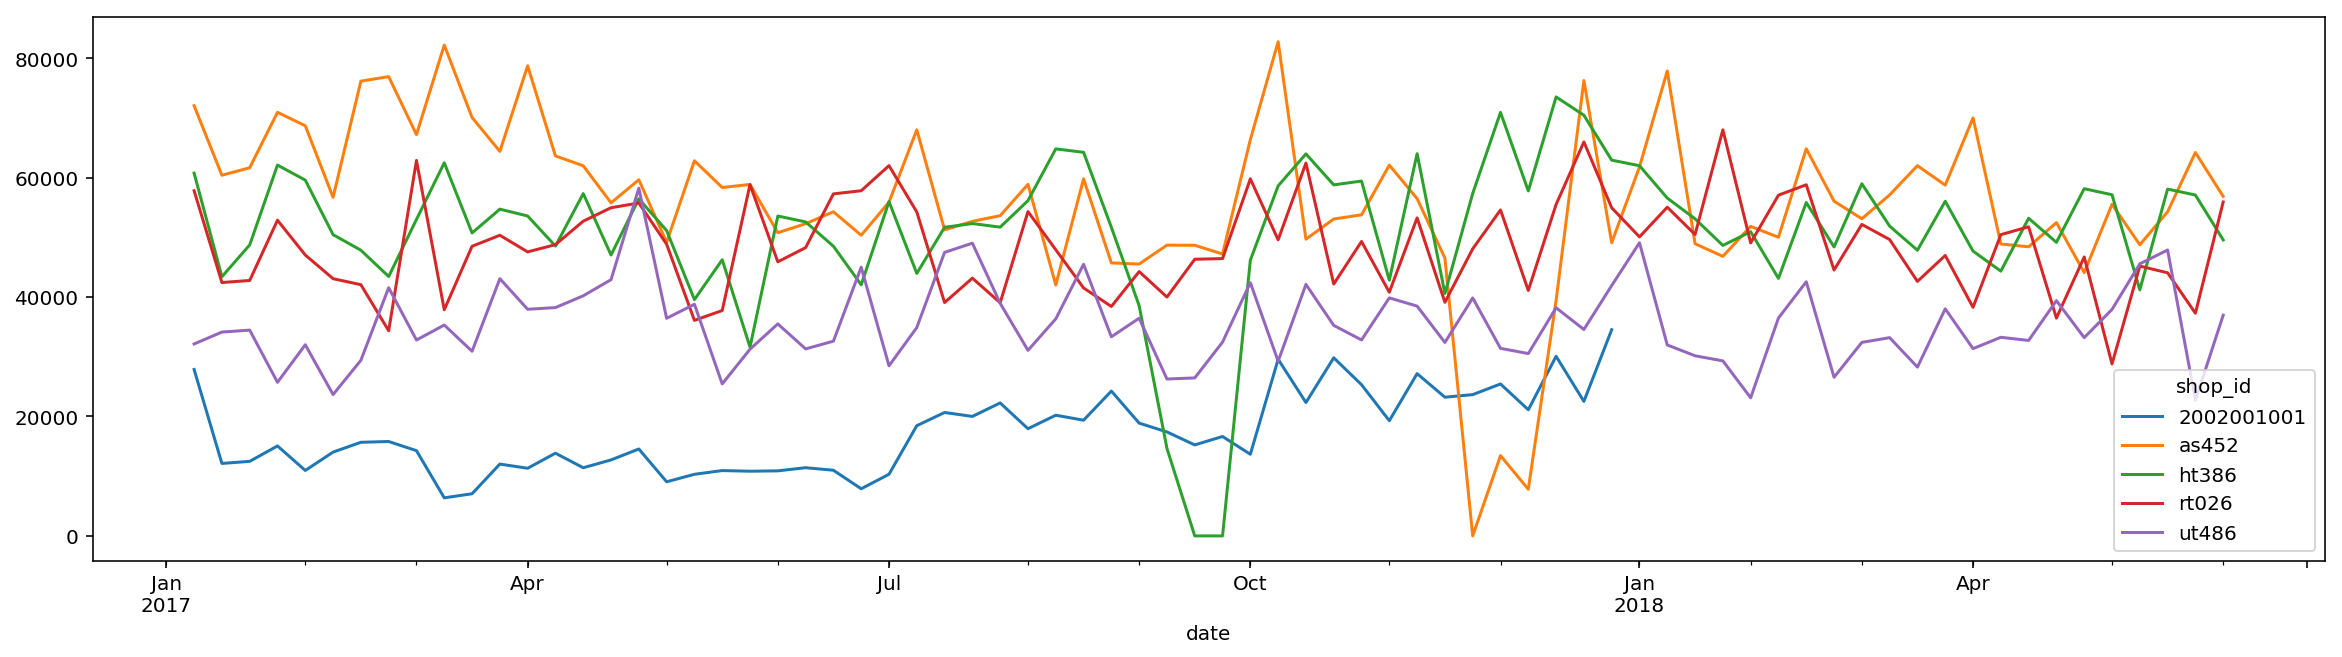

In [18]:
# Aggregate to monthly, plot a few for EDA

case00 = pd.read_csv('dataset_shops.csv', usecols = ['date', 'shop_id', 'committed_revenues_main_inc_vat', 'place'])
case00.date = pd.to_datetime(case00.date)

kpn_monthly = (case00.
              set_index('date').
              groupby(['place', 'shop_id']).
              resample('W').sum().reset_index().copy())

places = np.random.choice(kpn_monthly.shop_id.unique(), size = 5, replace = False)


kpn_monthly_mini = kpn_monthly[kpn_monthly.shop_id.isin(places)]
#kpn_monthly_mini = kpn_monthly[kpn_monthly.place == 'amsterdam']

plt.rcParams["figure.figsize"] = [20, 5]

kpn_plot = kpn_monthly_mini.pivot(index = 'date', columns = 'shop_id', values='committed_revenues_main_inc_vat')
kpn_plot.plot()

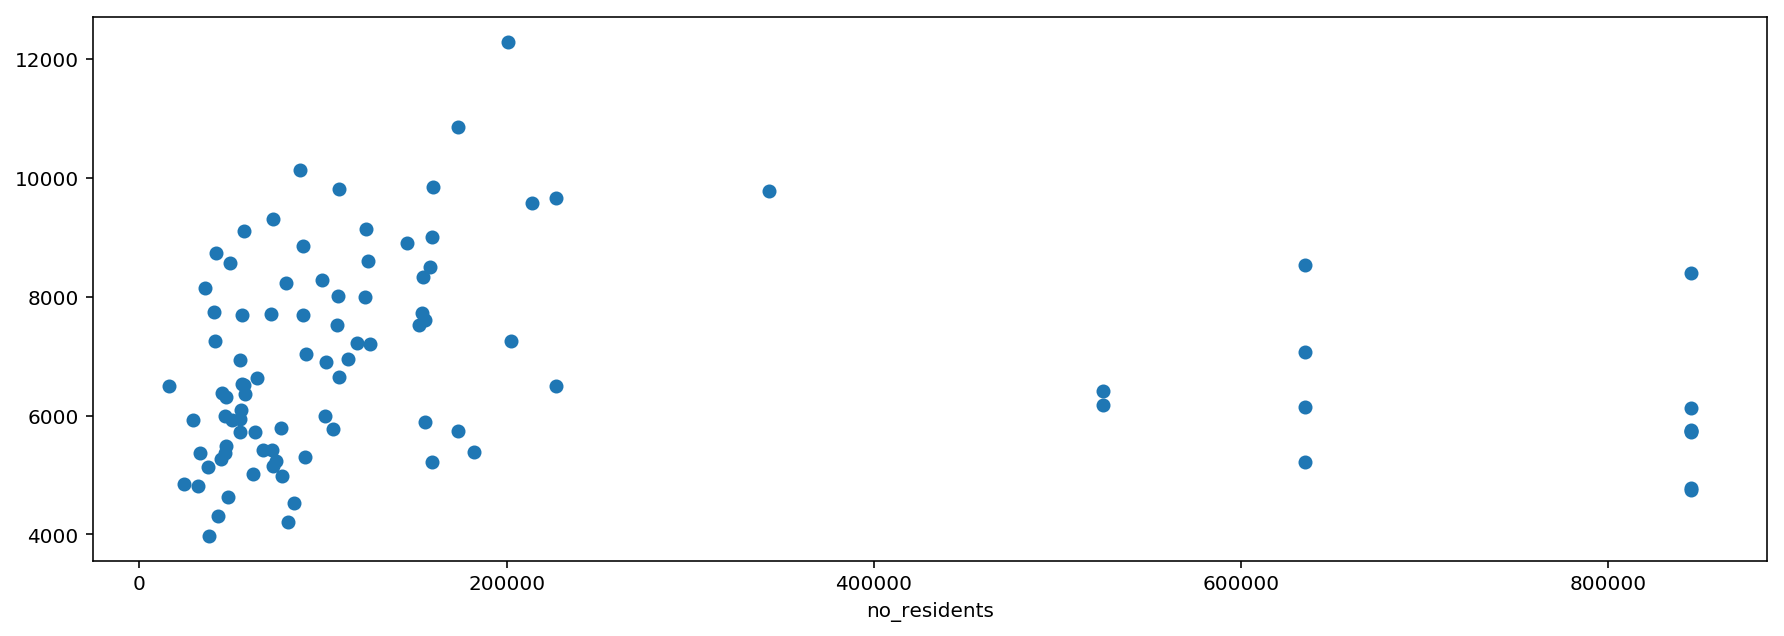

In [19]:
kpn = case0[case0.KPN == 1]

kpn2 = pd.merge(
    pd.DataFrame(kpn.groupby(['shop_id'])['committed_rev'].mean().round().reset_index()),
    kpn[['shop_id', 'place', 'dist_shop_closest_km', 'no_retail_shops',
       'no_companies', 'avg_household_size', 'no_residents']].drop_duplicates()
).dropna()

# kpn2[pd.isnull(kpn2).any(axis=1)]

# Make indicator w/ interaction, or quadratic

plt.rcParams["figure.figsize"] = [15, 5]
plt.scatter(x = kpn2.no_residents, y = kpn2.committed_rev)
plt.xlabel('no_residents')

# (1) NOTHING: perc_owned_vs_rented_houses, avg_household_size, avg_value_household
# (2) THIS PATTERN: no_residents, no_retail_shops, no_companies
# (3) UNCLEAR: 'dist_shop_closest_km',

pass;

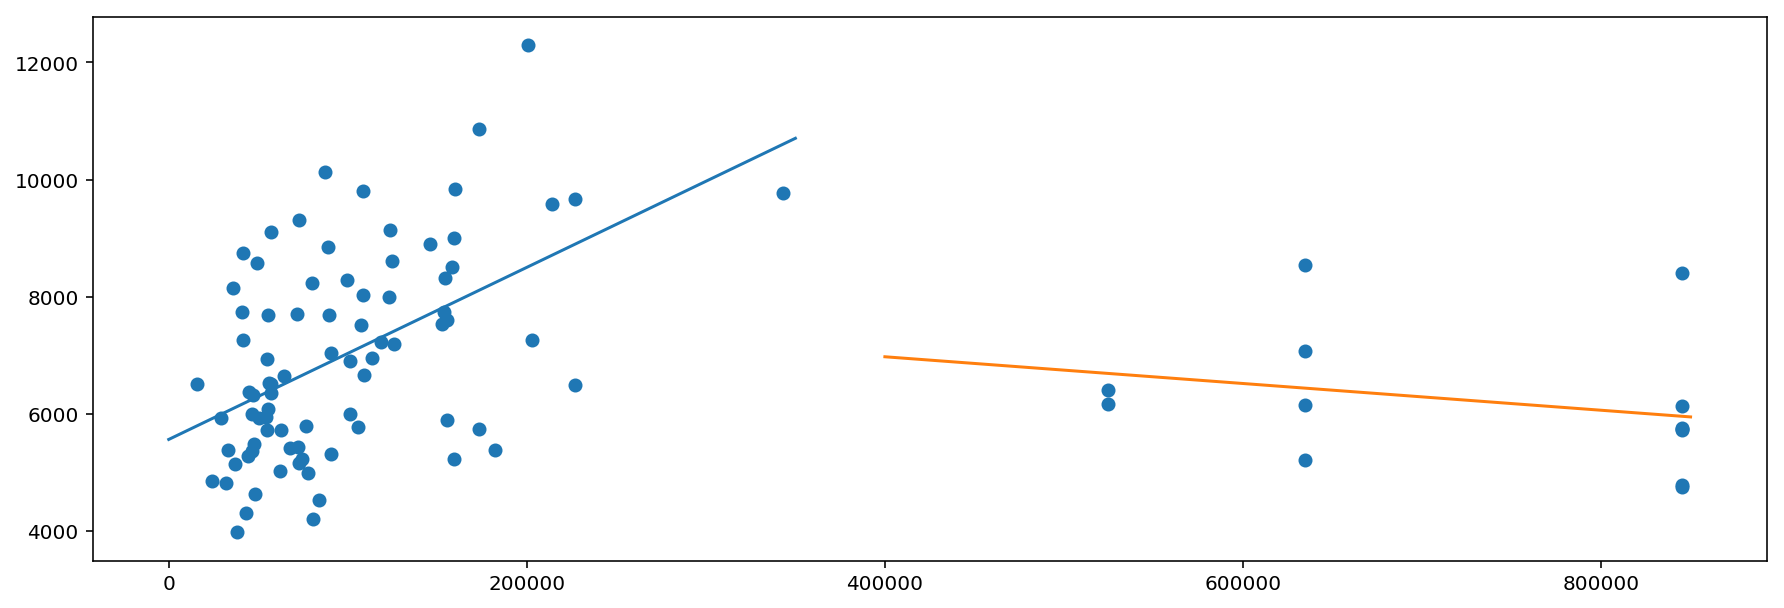

In [20]:
# Feature engineering: no_residents -- 

# Quadratic
# kpn2.loc[:,'no_residents2'] = kpn2.no_residents**2
# X = kpn2[['no_residents', 'no_residents2']] 
# X = sm.add_constant(X)

# Indicators
kpn2.loc[:,'no_residents_lt'] = np.where(kpn2.no_residents < 400000, kpn2.no_residents, 0)
kpn2.loc[:,'no_residents_gt'] = np.where(kpn2.no_residents > 400000, kpn2.no_residents, 0)
kpn2.loc[:, 'c_lt'] = (kpn2['no_residents_lt'] != 0)*1
kpn2.loc[:, 'c_gt'] = (kpn2['no_residents_gt'] != 0)*1
X = kpn2[['c_lt', 'no_residents_lt', 'c_gt', 'no_residents_gt']]

y = kpn2['committed_rev']

# Regression
mod = sm.OLS(y, X, missing='drop').fit()
mod.rsquared.round(2)

# ------------------------------

plt.rcParams["figure.figsize"] = [15, 5]

# Quadratic Regression plot
# x1 = np.arange(1, 900000, 50000)
# x = pd.DataFrame(data = {'int': 1, 'no_res': x1, 'no_res2': x1**2})
# plt.plot(x1, mod.predict(x))

# Indicator Regression Plot
x_lt = np.arange(1, 400000, 50000)
plt.plot(x_lt, mod.predict(pd.DataFrame(data = {'c_lt': 1, 'no_res_lt': x_lt, 'c_gt': 0, 'no_res_gt': 0})))
x_gt = np.arange(400000, 900000, 50000)
plt.plot(x_gt, mod.predict(pd.DataFrame(data = {'c_lt': 0, 'no_res_lt': 0,    'c_gt': 1, 'no_res_gt': x_gt})))


# Empirical Plot
plt.scatter(kpn2.no_residents, kpn2.committed_rev)

pass;

# Appendix

In [ ]:
# Also calculate R^2 Manually (Sanity check) -- 

from sklearn.metrics import r2_score

y_true = y
y_pred = mod.predict(X)

y_bar = y_true.mean()

SSReg = ((y_pred - y_bar)**2).sum()
SSRes = ((y_pred - y_true)**2).sum()
SSTot = ((y_true - y_bar)**2).sum()

# Model
mod.rsquared.round(2)

# Manually
(1 - SSRes/SSTot).round(2)

# sklearn 
(r2_score(y_true, y_pred)).round(2)

In [ ]:
# kpn = case0[case0.KPN == 1]

# # Shops per place --> only 7 places with > 1 shops
# (kpn[['place', 'shop_id']].
#  drop_duplicates().
#  groupby('place')['shop_id'].
#  count().
#  sort_values(ascending = False)
# )[:15]
